# Music Generation using GANs

In this notebook, we will use a simplified version of [C-RNN-GAN](https://arxiv.org/abs/1611.09904) to generate music. We will focus upon:
+ Utilities to prepare generator model
+ Utilities to prepare generator model
+ Data preparation
+ Utility to prepare custom training loop

We will make use of the same dataset we used in LSTM based music generation notebook. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PacktPublishing/Hands-On-Generative-AI-with-Python-and-TensorFlow-2/blob/master/Chapter_10/crnn_gan/simple_gan.ipynb)

## Import Libraries

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
from music21 import converter, instrument, note, chord, stream

from tensorflow.keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## Extract MIDI Dataset

In [ ]:
!unzip midi_dataset.zip

## Prepare Generator

In [4]:
def build_generator(latent_dim,seq_shape):

  model = Sequential()
  model.add(Dense(256, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(np.prod(seq_shape), activation='tanh'))
  model.add(Reshape(seq_shape))
  model.summary()

  noise = Input(shape=(latent_dim,))
  seq = model(noise)

  return Model(noise, seq)

## Prepare Discriminator

In [3]:
def build_discriminator(seq_shape):

  model = Sequential()
  model.add(LSTM(512, input_shape=seq_shape, return_sequences=True))
  model.add(Bidirectional(LSTM(512)))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  seq = Input(shape=seq_shape)
  validity = model(seq)

  return Model(seq, validity)

## Data Preparation Utility

In [5]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # Normalize input between -1 and 1
    network_input = (network_input - float(n_vocab)/2) / (float(n_vocab)/2)
    network_output = to_categorical(network_output)

    return (network_input, network_output)

## Utility to Transform Model output to MIDI

In [6]:
def create_midi(prediction_output, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for item in prediction_output:
        pattern = item[0]
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))

## Utilities for Training GAN

In [7]:
def generate(latent_dim, generator, input_notes,filename='gan_final'):
  # Get pitch names and store in a dictionary
  notes = input_notes
  pitchnames = sorted(set(item for item in notes))
  int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

  # Use random noise to generate sequences
  noise = np.random.normal(0, 1, (1, latent_dim))
  predictions = generator.predict(noise)

  pred_notes = [x*242+242 for x in predictions[0]]
  pred_notes = [int_to_note[int(x)] for x in pred_notes]

  create_midi(pred_notes, filename)

In [8]:
def plot_loss(disc_loss, gen_loss):
  plt.plot(disc_loss, c='red')
  plt.plot(gen_loss, c='blue')
  plt.title("GAN Loss per Epoch")
  plt.legend(['Discriminator', 'Generator'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
  plt.show()
  plt.close()

In [9]:
def train(latent_dim, 
          notes, 
          generator, 
          discriminator, 
          gan,
          epochs, 
          batch_size=128, 
          sample_interval=50):

  disc_loss =[]
  gen_loss = []

  n_vocab = len(set(notes))
  X_train, y_train = prepare_sequences(notes, n_vocab)

  # ground truths
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for epoch in range(epochs):

      idx = np.random.randint(0, X_train.shape[0], batch_size)
      real_seqs = X_train[idx]

      noise = np.random.normal(0, 1, (batch_size, latent_dim))

      # generate a batch of new note sequences
      gen_seqs = generator.predict(noise)

      # train the discriminator
      d_loss_real = discriminator.train_on_batch(real_seqs, real)
      d_loss_fake = discriminator.train_on_batch(gen_seqs, fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


      #  train the Generator
      noise = np.random.normal(0, 1, (batch_size, latent_dim))
      g_loss = gan.train_on_batch(noise, real)

      # visualize progress
      if epoch % sample_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, 
                                                               d_loss[0], 
                                                               100*d_loss[1], 
                                                               g_loss))
        disc_loss.append(d_loss[0])
        gen_loss.append(g_loss)
        generate(latent_dim, generator, notes,filename='gan_epoch'+str(epoch))
  generate(latent_dim, generator, notes)
  plot_loss(disc_loss,gen_loss)

## Prepare Generator, Discriminator and GAN Models

In [10]:
rows = 100
seq_length = rows
seq_shape = (seq_length, 1)
latent_dim = 1000

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator(seq_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_dim,seq_shape)

# The generator takes noise as input and generates note sequences
z = Input(shape=(latent_dim,))
generated_seq = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(generated_seq)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 512)          1052672   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              4198400   
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

## Prepare Dataset

In [11]:
from tqdm.notebook import tqdm

In [12]:
def get_notes():
    """ Get all the notes and chords from the midi files """
    notes = []

    for file in tqdm(glob.glob("midi_dataset/*.mid")):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
            
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

In [13]:
# Load and convert the data
notes = get_notes()

Parsing midi_dataset/Sechs Variationen.mid
Parsing midi_dataset/Waltz No.10b.mid
Parsing midi_dataset/Op.51.mid
Parsing midi_dataset/Piano Sonatina No.2 Op 49.mid
Parsing midi_dataset/Waltz No.1.mid
Parsing midi_dataset/Ten Easy Piano Pieces Slovak Peasant's Dance Mov.3.mid
Parsing midi_dataset/32 Variations on a theme.mid
Parsing midi_dataset/Piano version of Bachs two part inventions No.2.mid
Parsing midi_dataset/Unknown Piano Sonata Mov.3.mid
Parsing midi_dataset/Toccata and Fugue in D minor, BWV 565. (Busoni Piano Arr.mid
Parsing midi_dataset/Piano version of Bachs two part inventions No.3.mid
Parsing midi_dataset/Piano version of Bachs two part inventions No.14.mid
Parsing midi_dataset/Romance piano.mid
Parsing midi_dataset/Op33 No.4.mid
Parsing midi_dataset/Ten Easy Piano Pieces Aurora Mov.7.mid
Parsing midi_dataset/Sieben Bagatellen, in F Major, Opus.33, No.3.mid
Parsing midi_dataset/A Rumanian Dance No.1.mid
Parsing midi_dataset/Rondo Opus.51, No.1.mid
Parsing midi_dataset/Rhap

## Train the GAN

0 [D loss: 0.700599, acc.: 2.34%] [G loss: 0.690003]
5 [D loss: 0.330439, acc.: 87.50%] [G loss: 0.965924]
10 [D loss: 0.169127, acc.: 95.31%] [G loss: 2.610085]
15 [D loss: 0.522524, acc.: 78.12%] [G loss: 1.376299]
20 [D loss: 0.284567, acc.: 91.41%] [G loss: 2.609391]
25 [D loss: 0.248017, acc.: 91.41%] [G loss: 2.243087]
30 [D loss: 0.337728, acc.: 88.28%] [G loss: 2.095068]
35 [D loss: 0.339113, acc.: 81.25%] [G loss: 2.083154]
40 [D loss: 0.351858, acc.: 84.38%] [G loss: 1.952475]
45 [D loss: 0.273926, acc.: 90.62%] [G loss: 2.543951]
50 [D loss: 0.248093, acc.: 90.62%] [G loss: 2.172482]
55 [D loss: 0.271015, acc.: 91.41%] [G loss: 2.190949]
60 [D loss: 0.356364, acc.: 81.25%] [G loss: 1.983520]
65 [D loss: 0.405131, acc.: 81.25%] [G loss: 1.702689]
70 [D loss: 0.283381, acc.: 87.50%] [G loss: 2.024445]
75 [D loss: 0.393422, acc.: 80.47%] [G loss: 1.576271]
80 [D loss: 0.443313, acc.: 78.91%] [G loss: 1.448712]
85 [D loss: 0.478743, acc.: 78.91%] [G loss: 1.748747]
90 [D loss: 0

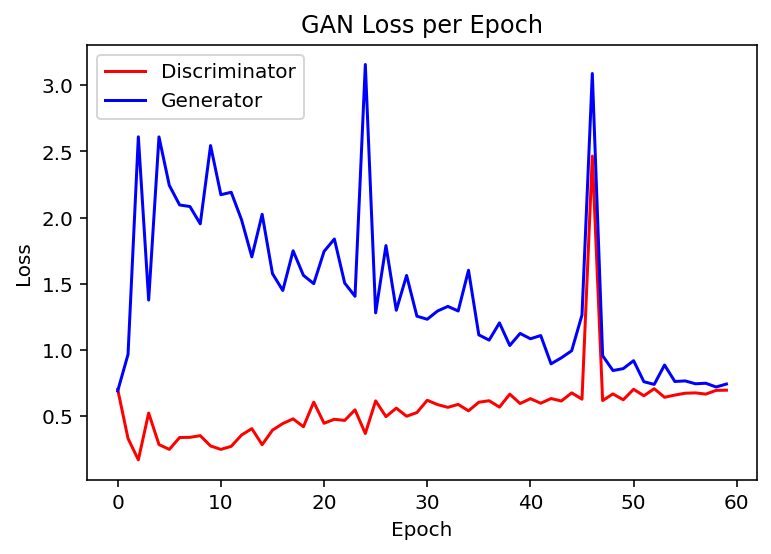

In [14]:
train(latent_dim, notes, generator, discriminator, gan,epochs=300, batch_size=64, sample_interval=5)